In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/sobibence/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sobibence/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sobibence/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#tokenizing and lemmatizing

stop_words   = set(stopwords.words('english'))
lemmatizer   = WordNetLemmatizer()

def tokenize_and_clean(text):
    #return empty string if not a valid string
    if not isinstance(text, str):
        return ""
    try:
        #tokenize the text
        tokens = word_tokenize(text)
    except Exception as e:
        print("Tokenization error:", e)
        return ""
    # Lowercase tokens to match stopwords and filter out stopwords and short tokens
    #tokens = [t.lower() for t in tokens if t.lower() not in stop_words and len(t) > 1]
    
    #lemmatize each token and return the cleaned text
    return ' '.join(lemmatizer.lemmatize(t) for t in tokens)

In [3]:
#more text cleaning functions

URL_PATTERN    = r'http\S+|www\.\S+'
MENTION_RE     = r'u\/\w+|r\/\w+'
PUNCT_DIGIT_RE = r'[^a-z\s]'

#removing links and mentions from the text
def strip_urls_mentions(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(URL_PATTERN, ' ', text)
    text = re.sub(MENTION_RE, ' ', text)
    return text

#removing punctuation and digits from the text
def strip_punct_and_digits(text):
    if not isinstance(text, str):
        text = str(text)
    return re.sub(PUNCT_DIGIT_RE, ' ', text)

#expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

#clean extra spaces
def strip_extra_spaces(text):
    if not isinstance(text, str):
        text = str(text)
    #replace runs of whitespace (spaces, tabs, newlines) with a single space
    cleaned = re.sub(r'\s+', ' ', text)
    return cleaned.strip()

#initialize vader sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()


In [4]:
# applying functions to the dataframe

def clean_for_sentiment(df, source_col='full_text'):
    df = df.copy()
    # 2. remove reddit mentions and urls
    df['full_text'] = df['full_text'].map(strip_urls_mentions)
    # 3. strip punctuation/digits
    df['full_text'] = df['full_text'].map(strip_punct_and_digits)
    # 4. expand contractions - i cant make the library work
    df['full_text'] = df['full_text'].map(expand_contractions)
    # 5. tokenize, remove stopwords & lemmatize
    df['full_text'] = df['full_text'].map(tokenize_and_clean)
    # 6. remove extra spaces
    df['full_text'] = df['full_text'].map(strip_extra_spaces)
    # 7. drop any rows that are now empty
    df = df[df['full_text'].str.strip().astype(bool)]
    return df


In [5]:
#sentiment scoring and weight computation

def enrich_sentiment_with_votes(df, thread_weight=0.3):
    df = df.copy()
    # 1) sentiment stays the same
    df['sentiment'] = df['full_text'].map(
        lambda t: vader_analyzer.polarity_scores(t)['compound']
    )
    # 2) combine comment & thread votes
    df['vote_score'] = (
        df['comment_score'] 
        + thread_weight * df['thread_score']
    )
    # 3) convert to a sign‐preserving, log‐scaled weight:
    #    weight = sign(vote_score) * log1p(|vote_score|)
    df['weight'] = np.sign(df['vote_score']) * np.log1p(np.abs(df['vote_score']))
    return df


In [6]:
#helper to slice a dataframe by a start, end window
def slice_period(df, start, end=None):
    if end is not None:
        return df[(df.comment_time_utc >= start) & (df.comment_time_utc < end)]
    else:
        return df[df.comment_time_utc >= start]

In [7]:
#defining the three windows per coin
periods = {
    'trump': {
        'launch':    ('2025-01-17', '2025-01-20'),
        'pump':      ('2025-01-20', '2025-02-02'),
        'post-pump/dump': ('2025-02-02', None),
    },
    'melania': {
        'launch':    ('2025-01-19', '2025-01-22'),
        'pump':      ('2025-01-22', '2025-01-24'),
        'post-pump/dump': ('2025-01-24', None),
    },
    'libra': {
        'launch':    ('2025-02-14', '2025-02-16'),
        'pump':      ('2025-02-16', '2025-02-19'),
        'post-pump/dump': ('2025-02-19', None),
    },
}

In [8]:
def preprocess_text(file_path):
    df = pd.read_csv(file_path)
    #parse the time columns to UTC
    df['thread_time_utc']  = pd.to_datetime(df['thread_time_utc'],  utc=True)
    df['comment_time_utc'] = pd.to_datetime(df['comment_time_utc'], utc=True)

    #dropping the columns that are after the thread time 2025-02-28
    cutoff = pd.to_datetime('2025-02-28', utc=True)
    df.drop(df[df['comment_time_utc'] > cutoff].index, inplace=True)

    #merge titles and comments into one column for better context
    df['full_text'] = df['thread_title'] + ' - ' + df['comment_text']

    #reassign the cleaned DataFrame back to df
    df = clean_for_sentiment(df)
    df = enrich_sentiment_with_votes(df)
 
    return df


In [9]:
#compute unweighted & weighted averages for each coin/phase
df_trump    = preprocess_text('merged_trump.csv')
df_melania  = preprocess_text('merged_melania.csv')
df_libra   = preprocess_text('merged_libra.csv')

results = []
for coin, df in [('trump', df_trump), ('melania', df_melania), ('libra', df_libra)]:
    for phase, (start, end) in periods[coin].items():
        sub = slice_period(df, start, end)
        if len(sub)==0:
            continue
        unweighted = sub['sentiment'].mean()
        weighted   = (sub['sentiment'] * sub['weight']).sum() / sub['weight'].abs().sum()
        results.append({
            'coin': coin,
            'phase': phase,
            'n_comments': len(sub),
            'sent_unweighted': unweighted,
            'sent_weighted':   weighted,
        })

summary = pd.DataFrame(results)
print(summary)


      coin           phase  n_comments  sent_unweighted  sent_weighted
0    trump          launch       13318         0.050727       0.050193
1    trump            pump       23688        -0.069798      -0.117750
2    trump  post-pump/dump       19756         0.013098       0.015688
3  melania          launch        9771        -0.034997      -0.028136
4  melania            pump         649        -0.086190      -0.097212
5  melania  post-pump/dump        5465         0.041339       0.000512
6    libra          launch         361        -0.068691      -0.043458
7    libra            pump         657         0.050951       0.068749
8    libra  post-pump/dump         945        -0.045363      -0.040604


In [10]:
#saving th ecleaned dataframes to csv so we can use them later

df_trump.to_csv('df_trump.csv', index=False)
df_melania.to_csv('df_melania.csv', index=False)
df_libra.to_csv('df_libra.csv', index=False)


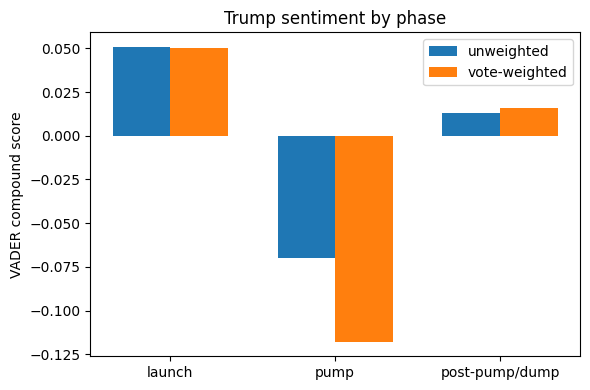

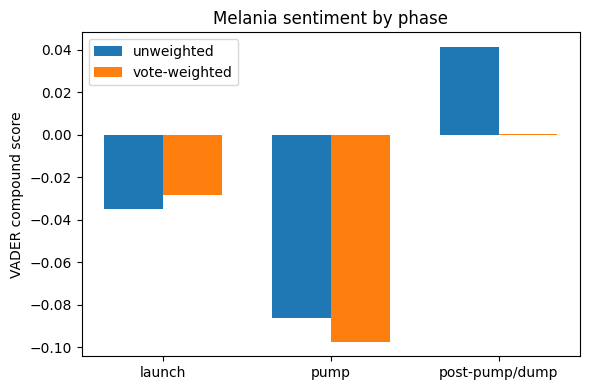

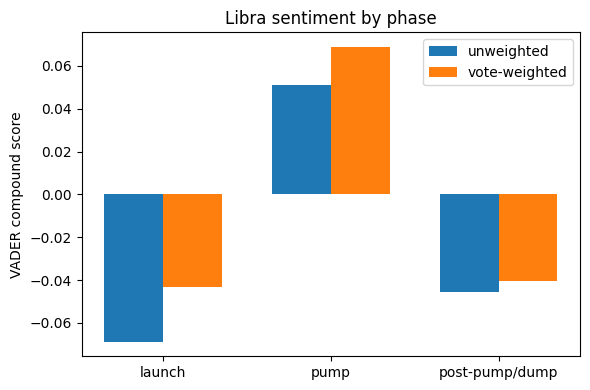

In [11]:
#plotting the results
for coin in summary['coin'].unique():
    dfc = summary[summary['coin']==coin]
    x = np.arange(len(dfc))
    width = 0.35

    plt.figure(figsize=(6,4))
    plt.bar(x - width/2, dfc['sent_unweighted'], width, label='unweighted')
    plt.bar(x + width/2, dfc['sent_weighted'],   width, label='vote-weighted')
    plt.xticks(x, dfc['phase'])
    plt.ylabel('VADER compound score')
    plt.title(f'{coin.title()} sentiment by phase')
    plt.legend()
    plt.tight_layout()
    plt.show()

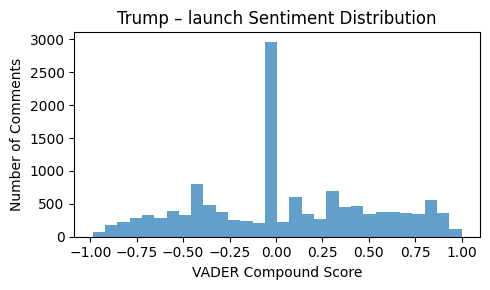

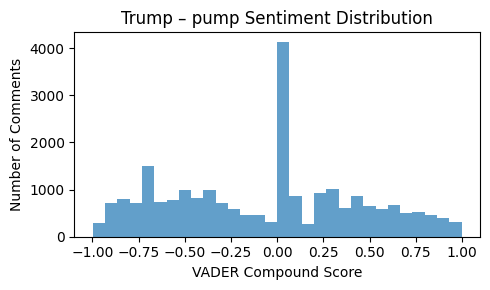

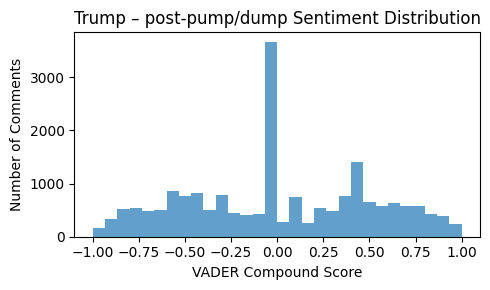

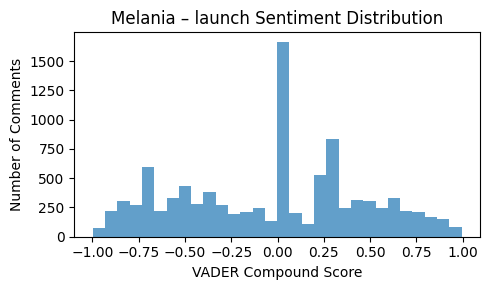

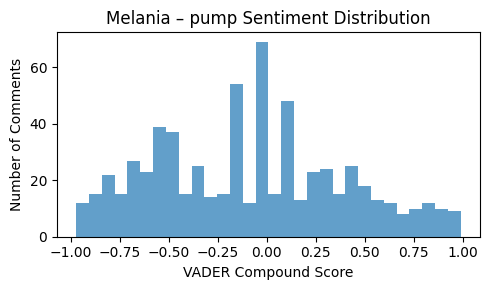

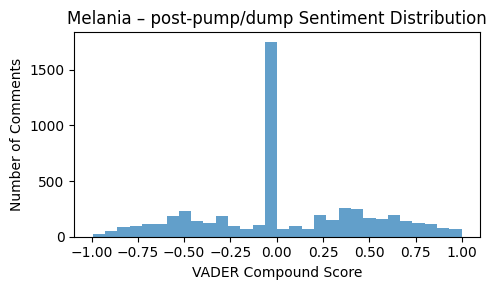

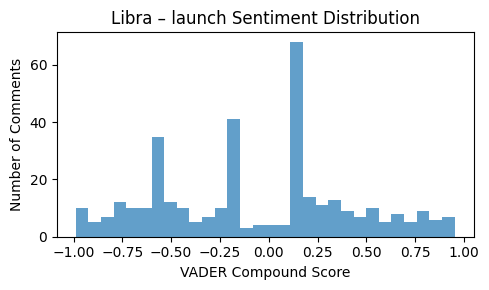

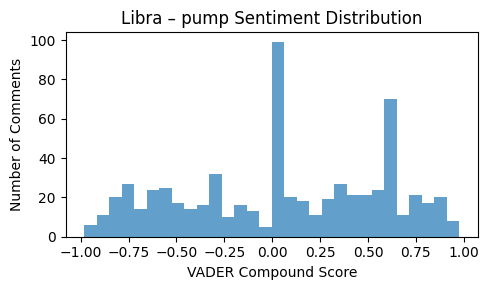

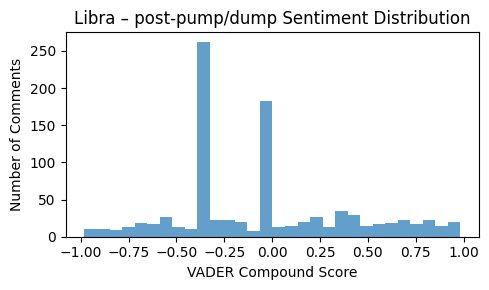

In [12]:
for coin, df in [('trump', df_trump), ('melania', df_melania), ('libra', df_libra)]:
    for phase, (start, end) in periods[coin].items():
        sub = slice_period(df, start, end)
        if sub.empty: continue

        plt.figure(figsize=(5,3))
        plt.hist(sub['sentiment'], bins=30, alpha=0.7)
        plt.title(f'{coin.title()} – {phase} Sentiment Distribution')
        plt.xlabel('VADER Compound Score')
        plt.ylabel('Number of Comments')
        plt.tight_layout()
        plt.show()


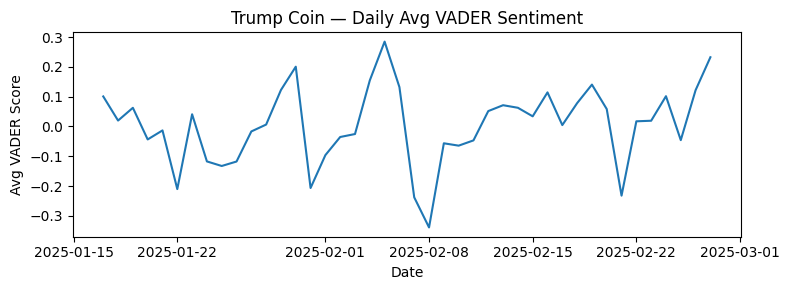

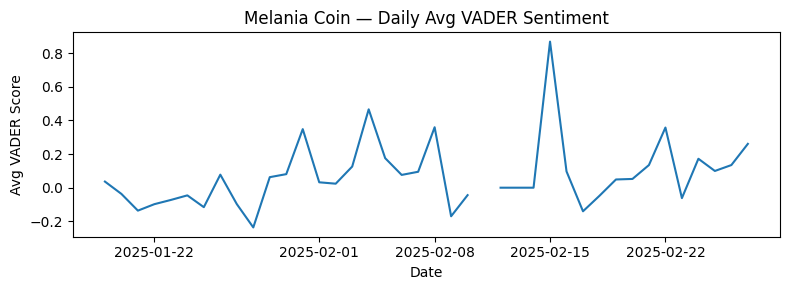

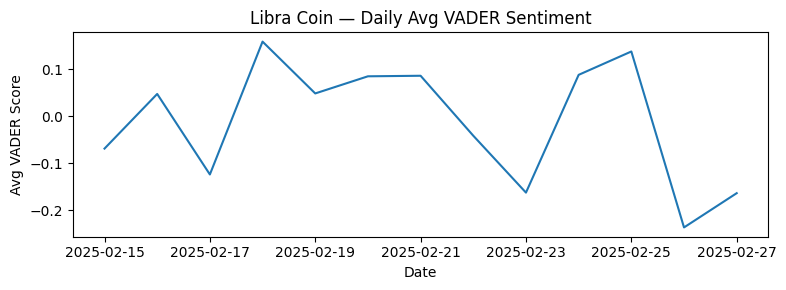

In [13]:

coin_dfs = {
    'trump':   df_trump,
    'melania': df_melania,
    'libra':   df_libra,
}

for coin, df in coin_dfs.items():
    ts = df.set_index('comment_time_utc').sort_index()

    daily_unw = ts['sentiment'].resample('D').mean()

    plt.figure(figsize=(8, 3))
    plt.plot(daily_unw.index, daily_unw.values)
    plt.title(f'{coin.title()} Coin — Daily Avg VADER Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Avg VADER Score')
    plt.tight_layout()
    plt.show()


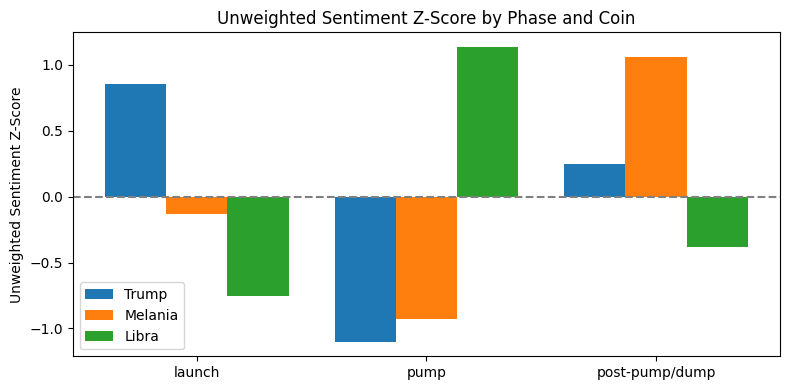

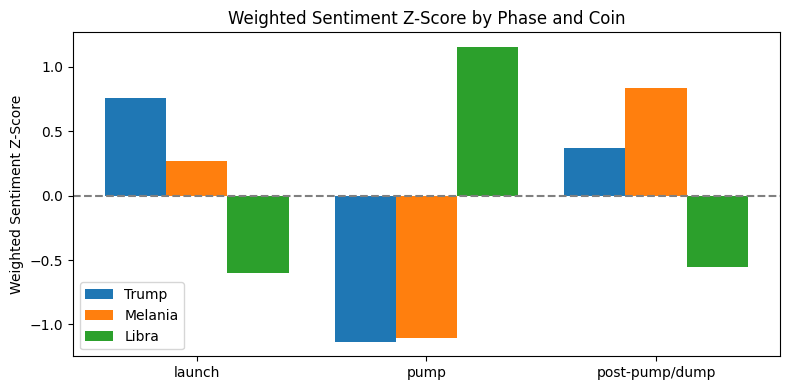

In [ ]:
#calculating z-scores for unweighted and weighted sentiment
summary['z_unweighted'] = summary.groupby('coin')['sent_unweighted'] \
                                 .transform(lambda x: (x - x.mean()) / x.std())
summary['z_weighted']   = summary.groupby('coin')['sent_weighted']   \
                                 .transform(lambda x: (x - x.mean()) / x.std())

#plotting z-scores by phase
def plot_phase_z(summary, col, ylabel):
    coins  = summary['coin'].unique()
    phases = summary['phase'].unique()
    x      = np.arange(len(phases))
    width  = 0.8 / len(coins)

    plt.figure(figsize=(8, 4))
    for i, coin in enumerate(coins):
        dfc = summary[summary['coin'] == coin]
        plt.bar(x + (i - (len(coins)-1)/2)*width,
                dfc[col],
                width,
                label=coin.capitalize())
    plt.xticks(x, phases)
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} by Phase and Coin')
    plt.legend()
    plt.tight_layout()
    plt.show()

#drawing both charts
plot_phase_z(summary, 'z_unweighted', 'Unweighted Sentiment Z-Score')
plot_phase_z(summary, 'z_weighted',   'Weighted Sentiment Z-Score')
